# Testing Forward and Inverse Hankel Transform #

This is a simple demo to show how to compute the forward and inverse Hankel transform.

We use the function $f(r) = 1/r$ as an example function.  This function is unbounded at $r=0$ and therefore causes problems with convergence at the origin. 

In [16]:
# Import libraries

import numpy as np                                                      # To define grid
from hankel import HankelTransform                                      # Transforms

from scipy.interpolate import InterpolatedUnivariateSpline as spline    # Spline

import matplotlib.pyplot as plt                                         # Plotting
%matplotlib inline

In [2]:
# Define grid

r = np.linspace(1e-2,1,1000)                       # Define a physical grid
k = np.logspace(-3,2,100)                          # Define a spectral grid

In [3]:
# Compute Forward Hankel transform

f    = lambda x : 1/x                              # Sample Function
h    = HankelTransform(nu=0,N=1000,h=0.005)        # Create the HankelTransform instance, order zero
hhat = h.transform(f,k,ret_err=False)              # Return the transform of f at k.

In [4]:
# Compute Inverse Hankel transform

hhat_sp = spline(k, hhat)                              # Define a spline to approximate transform
f_new = h.transform(hhat_sp, r, False, inverse=True)  # Compute the inverse transform

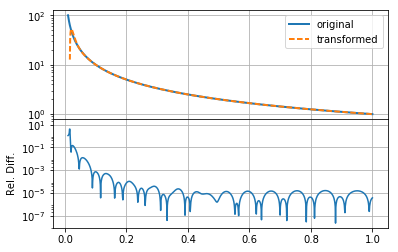

In [15]:
# Plot the original function and the transformed functions
fig,ax = plt.subplots(2,1,sharex=True,gridspec_kw={"hspace":0})

ax[0].semilogy(r,f(r), linewidth=2,label='original')
ax[0].semilogy(r,f_new,ls='--',linewidth=2,label='transformed')
ax[0].grid('on')
ax[0].legend(loc='best')
#ax[0].axis('on')

ax[1].plot(r,np.abs(f(r)/f_new-1))
ax[1].set_yscale('log')
ax[1].set_ylim(None,30)
ax[1].grid('on')
ax[1].set_ylabel("Rel. Diff.")
plt.show()

In practice, there are three aspects that affect the accuracy of the round-trip transformed function, other than the features of the function itself: 

1. the value of ``N``, which controls the the upper limit of the integral (and must be high enough for convergence), 
2. the value of ``h``, which controls the resolution of the array used to do integration. Most importantly, controls the position of the *first sample* of the integrand. In a function such as $1/r$, or something steeper, this must be small to capture the large amount of information at low $r$.
3. the resolution/range of $k$, which is used to define the function which is inverse-transformed.